# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
print(tf.__version__)

2024-04-18 07:41:16.048181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 07:41:16.048219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 07:41:16.072244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 07:41:16.124745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


In [2]:
from MachineLearningUtils.system_setup.gpu import activate_gpu
activate_gpu()

1 Physical GPUs, 1 Logical GPU


2024-04-18 07:41:18.971380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 07:41:19.182411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 07:41:19.182603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Video N°183: Getting helper functions ready and downloading data to model

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [3]:
# Import series of helper functions for our notebook
from MachineLearningUtils.data_acquisition.data_downloader import *
from MachineLearningUtils.data_visualization.augmentation_effects import *
from MachineLearningUtils.data_visualization.evaluation_metrics import *
from MachineLearningUtils.data_visualization.image_visualization import *
from MachineLearningUtils.data_visualization.model_learning_curves import *
from MachineLearningUtils.data_visualization.prediction_visualization import *
from MachineLearningUtils.training_utilities.model_callbacks import *
from MachineLearningUtils.training_utilities.transfer_learning import *

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/image_data_modification.ipynb

In [4]:
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip"
download_data(url=url, file_path="101_food_classes_10_percent.zip", extract=True)

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

The file 101_food_classes_10_percent.zip already exists.
Extracting 101_food_classes_10_percent.zip as ZIP...
101_food_classes_10_percent.zip has been extracted to current directory.


In [5]:
# How many images/classes are there?
walk_through_dir(dir_path="101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_

In [6]:
# Args for image_dataset_from_directory
idfd_args={
    "image_size":(224, 224),
    "label_mode":"categorical",
    "batch_size":32
}

In [7]:
# Setup data inputs
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                **idfd_args)
# Don't shuffle test data for prediction analysis
# There is no point in mixing a set of test data anyway.
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Video N°184: Outlining the model we're going to build and building a ModelCheckpoint callback

## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

Video N°185: Creating a data augmentation layer to use with our model

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1./255) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

Video N°186: Creating a headless EfficientNetB0 model with data augmentation built in

Rappel:
#159: Note: Fixes for EfficientNetB0 model creation + weight loading
**Old:**
```python
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
```
**New:**
```python
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
```

In [10]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode se weights wich need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

Video N°187: Fitting and evaluating our biggest transfer learning model yet

In [12]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5


2024-04-18 07:41:41.187024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-18 07:41:43.228974: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2f0e74f6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-18 07:41:43.228999: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-04-18 07:41:43.250912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713418903.388250    4156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 337s 1s/step - loss: 3.5216 - accuracy: 0.2397 - val_loss: 2.7868 - val_accuracy: 0.3649
Epoch 2/5
237/237 [==============================] - 264s 1s/step - loss: 2.4191 - accuracy: 0.4473 - val_loss: 2.2633 - val_accuracy: 0.4680
Epoch 3/5
237/237 [==============================] - 232s 975ms/step - loss: 2.0458 - accuracy: 0.5185 - val_loss: 2.0947 - val_accuracy: 0.4931
Epoch 4/5
237/237 [==============================] - 205s 864ms/step - loss: 1.8320 - accuracy: 0.5545 - val_loss: 1.9519 - val_accuracy: 0.5172
Epoch 5/5
237/237 [==============================] - 175s 740ms/step - loss: 1.6760 - accuracy: 0.5925 - val_loss: 1.8764 - val_accuracy: 0.5204


In [13]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6230 - accuracy: 0.5739


[1.623042345046997, 0.5739009976387024]

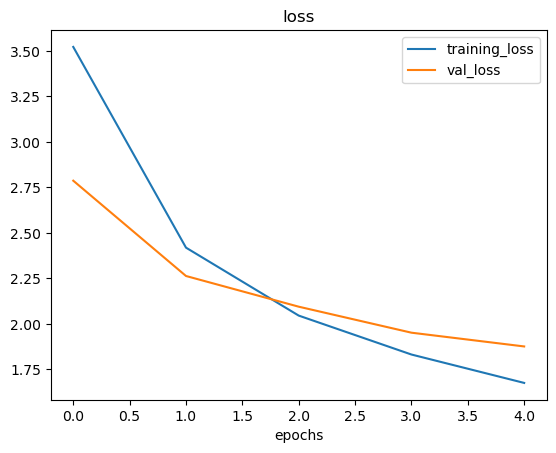

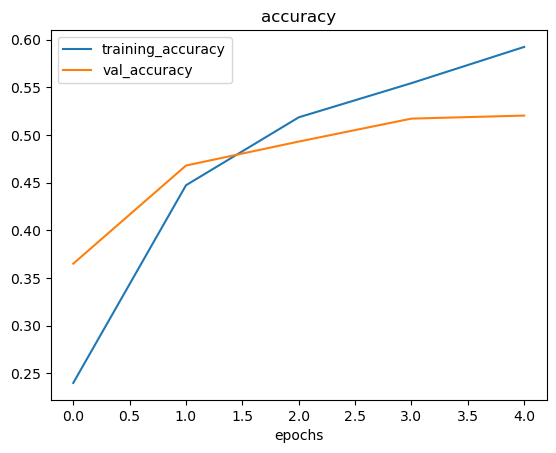

In [14]:
plot_loss_curves(history=history_all_classes_10_percent)

> **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

Video N°188: Unfreezing some layers in our base model to prepare for fine-tuning

## Fine-tuning

In [15]:
configure_trainable_layers(model=model, n_trainable_layers=5, verbose=True)

Layer 1: input_layer, Trainable: True
Layer 2: data_augmentation, Trainable: True
Layer 3: efficientnetv2-b0, Trainable: True
Layer 4: global_avg_pool_layer, Trainable: True
Layer 5: output_layer, Trainable: True


In [16]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [18]:
# Check which layers are traiable in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_activ

Video N°189: Fine-tuning our feature extraction model and evaluating its performance

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 1237s 5s/step - loss: 1.3331 - accuracy: 0.6430 - val_loss: 1.5338 - val_accuracy: 0.5908
Epoch 6/10
237/237 [==============================] - 788s 3s/step - loss: 1.0103 - accuracy: 0.7241 - val_loss: 1.6284 - val_accuracy: 0.5747
Epoch 7/10
237/237 [==============================] - 594s 3s/step - loss: 0.7621 - accuracy: 0.7893 - val_loss: 1.6876 - val_accuracy: 0.5644
Epoch 8/10
237/237 [==============================] - 541s 2s/step - loss: 0.5715 - accuracy: 0.8368 - val_loss: 1.8148 - val_accuracy: 0.5662
Epoch 9/10
237/237 [==============================] - 488s 2s/step - loss: 0.3925 - accuracy: 0.8853 - val_loss: 1.8963 - val_accuracy: 0.5601
Epoch 10/10
237/237 [==============================] - 391s 2s/step - loss: 0.2940 - accuracy: 0.9108 - val_loss: 2.2792 - val_accuracy: 0.5368


In [20]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 49s 62ms/step - loss: 1.7947 - accuracy: 0.6130


[1.7946510314941406, 0.6129900813102722]

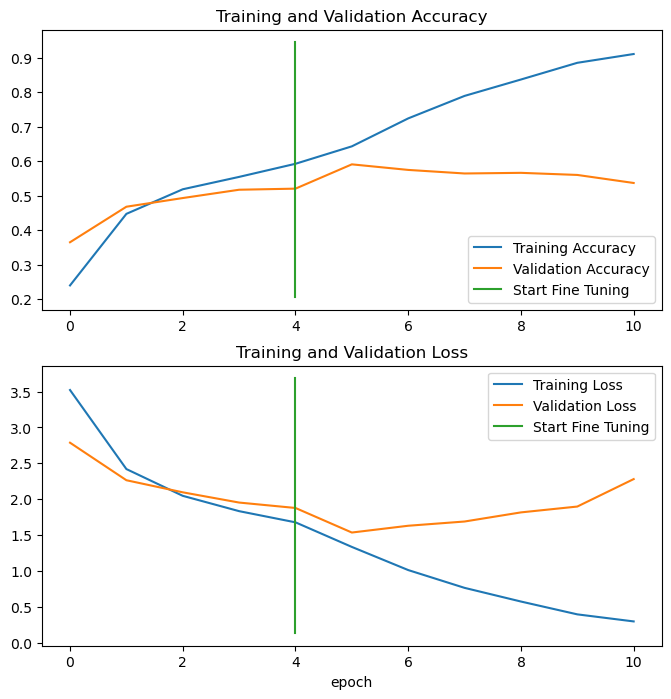

In [21]:
# Compare the histories of feature extraction model with fine-tuning model
compare_histories(original_history=history_all_classes_10_percent,
                  new_history=history_all_classes_10_percent_fine_tune,
                  initial_epochs=5)

Video N°190: Saving and loading our trained model

## Saving and loading our model

To use our model in an external application we'll need to save it and export it somewhere.

In [22]:
big_dog_model_name = "101_food_classes_10_percent_saved_big_dog_model" 

In [23]:
# Save our fine-tuning model
model.save(filepath=big_dog_model_name)

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model/assets


> 🔑 **Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [24]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model(filepath=big_dog_model_name)

In [25]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 50s 62ms/step - loss: 1.7947 - accuracy: 0.6130


[1.7946510314941406, 0.6129900813102722]

In [26]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.7946510314941406, 0.6129900813102722]

Video N°191: Downloading a pretrained model to make and evaluate predictions with

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [27]:
# Download pretrained model (one that was prepared earlier, so all predictions are similar)
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip"
download_data(url=url, file_path="06_101_food_class_10_percent_saved_big_dog_model.zip", extract=True)

The file 06_101_food_class_10_percent_saved_big_dog_model.zip already exists.
Extracting 06_101_food_class_10_percent_saved_big_dog_model.zip as ZIP...
06_101_food_class_10_percent_saved_big_dog_model.zip has been extracted to current directory.


In [28]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 62s 77ms/step - loss: 1.8027 - accuracy: 0.6078


[1.802719235420227, 0.6077623963356018]

Video N°192: Making predictions with our trained model on 25250 test  samples

## Making predictions with our trained model

In [30]:
# Make predictions with model
# NB: test_data must be the same format as the one used to train the model. Example (224, 224, 3)
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left
preds_probs

790/790 [==============================] - 58s 72ms/step


array([[5.9542075e-02, 3.5742519e-06, 4.1377105e-02, ..., 1.4138838e-09,
        8.3531369e-05, 3.0897786e-03],
       [9.6401703e-01, 1.3753144e-09, 8.4778655e-04, ..., 5.4285505e-05,
        7.8361935e-12, 9.8465291e-10],
       [9.5925927e-01, 3.2534070e-05, 1.4866914e-03, ..., 7.1889457e-07,
        5.4399629e-07, 4.0275565e-05],
       ...,
       [1.5138710e-05, 4.0972949e-04, 8.0249551e-10, ..., 2.1742768e-05,
        1.0797297e-05, 5.3789866e-01],
       [5.9318044e-03, 4.9236827e-03, 9.9822693e-03, ..., 1.1989535e-04,
        1.6890313e-05, 4.5218010e-02],
       [3.1363595e-02, 7.5052613e-03, 4.2974955e-04, ..., 5.0346559e-04,
        5.2056807e-06, 6.9062763e-01]], dtype=float32)

In [31]:
len(test_data)

790

In [32]:
# How many predictions are there?
len(preds_probs)

25250

In [33]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [34]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542075e-02, 3.5742519e-06, 4.1377105e-02, ..., 1.4138838e-09,
        8.3531369e-05, 3.0897786e-03],
       [9.6401703e-01, 1.3753144e-09, 8.4778655e-04, ..., 5.4285505e-05,
        7.8361935e-12, 9.8465291e-10],
       [9.5925927e-01, 3.2534070e-05, 1.4866914e-03, ..., 7.1889457e-07,
        5.4399629e-07, 4.0275565e-05],
       ...,
       [4.7313046e-01, 1.2931298e-07, 1.4805519e-03, ..., 5.9749861e-04,
        6.6969042e-05, 2.3469616e-05],
       [4.4572026e-02, 4.7265883e-07, 1.2258436e-01, ..., 6.3498255e-06,
        7.5319513e-06, 3.6778969e-03],
       [7.2438651e-01, 1.9249835e-09, 5.2311112e-05, ..., 1.2291525e-03,
        1.5792978e-09, 9.6396252e-05]], dtype=float32)

In [35]:
# What does the first prediction probability array look like?
preds_probs[0]

array([5.9542075e-02, 3.5742519e-06, 4.1377105e-02, 1.0660675e-09,
       8.1614733e-09, 8.6640455e-09, 8.0927953e-07, 8.5652562e-07,
       1.9859333e-05, 8.0978435e-07, 3.1727978e-09, 9.8674286e-07,
       2.8532467e-04, 7.8050066e-10, 7.4230676e-04, 3.8916518e-05,
       6.4741098e-06, 2.4977680e-06, 3.7891088e-05, 2.0678442e-07,
       1.5538551e-05, 8.1508250e-07, 2.6230564e-06, 2.0010719e-07,
       8.3828002e-07, 5.4216125e-06, 3.7391171e-06, 1.3150555e-08,
       2.7761464e-03, 2.8052071e-05, 6.8562794e-10, 2.5574898e-05,
       1.6689053e-04, 7.6408008e-10, 4.0453312e-04, 1.3150755e-08,
       1.7957562e-06, 1.4448336e-06, 2.3062818e-02, 8.2467471e-07,
       8.5365667e-07, 1.7138624e-06, 7.0525689e-06, 1.8402268e-08,
       2.8553313e-07, 7.9485108e-06, 2.0681648e-06, 1.8525253e-07,
       3.3620083e-08, 3.1522411e-04, 1.0410940e-05, 8.5448261e-07,
       8.4741843e-01, 1.0555443e-05, 4.4094534e-07, 3.7404097e-05,
       3.5306184e-05, 3.2489246e-05, 6.7315115e-05, 1.2852638e

In [36]:
len(preds_probs[0]), sum(preds_probs[0])

(101, 1.0000000628516963)

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [37]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542075e-02 3.5742519e-06 4.1377105e-02 1.0660675e-09 8.1614733e-09
 8.6640455e-09 8.0927953e-07 8.5652562e-07 1.9859333e-05 8.0978435e-07
 3.1727978e-09 9.8674286e-07 2.8532467e-04 7.8050066e-10 7.4230676e-04
 3.8916518e-05 6.4741098e-06 2.4977680e-06 3.7891088e-05 2.0678442e-07
 1.5538551e-05 8.1508250e-07 2.6230564e-06 2.0010719e-07 8.3828002e-07
 5.4216125e-06 3.7391171e-06 1.3150555e-08 2.7761464e-03 2.8052071e-05
 6.8562794e-10 2.5574898e-05 1.6689053e-04 7.6408008e-10 4.0453312e-04
 1.3150755e-08 1.7957562e-06 1.4448336e-06 2.3062818e-02 8.2467471e-07
 8.5365667e-07 1.7138624e-06 7.0525689e-06 1.8402268e-08 2.8553313e-07
 7.9485108e-06 2.0681648e-06 1.8525253e-07 3.3620083e-08 3.1522411e-04
 1.0410940e-05 8.5448261e-07 8.4741843e-01 1.0555443e-05 4.4094534e-07
 3.7404097e-05 3.5306184e-05 3.2489246e-05 6.7315115e-05 1.2852638e-08
 2.6219701e-10 1.0318226e-05 8.5743530e-05 1.

In [38]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [39]:
# How many pred classes do we have?
len(pred_classes)

25250

Video N°193: Unravelling our test dataset for comparing ground truth labels to predictions

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [40]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the \"1\" occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
# How many y_labels are there?
len(y_labels)

25250

In [42]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

Video N°194: Confirming our model's predictions are in the same order as the test labels

## Evaluating our model's predictions

One way to check that our model's predictions array (`pred_classes`) is in the same order as our test labels array (`y_labels`) is to find the accuracy score.

In [43]:
results_downloaded_model

[1.802719235420227, 0.6077623963356018]

In [44]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [45]:
# Does this metric come close to our model's evaluate results
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

Video N°195: Creating a confusion matrix for our model's 101 different classes

## Let's get visual: making a confusion matrix

In [46]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [47]:
len(y_labels), len(pred_classes)

(25250, 25250)

In [48]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_names, figsize=(100, 100), text_size=20, savefig=True, xlabels_rotation=90)

Video N°196: Evaluating every individual class in our dataset

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [50]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

Let's plot all of our classes F1-scores...

In [51]:
# Display f1-scores into dataframe with my personnal class
crp = ClassificationReportProcessor(y_true=y_labels, y_pred=pred_classes, class_names=class_names)
f1_scores = crp.f1_scores
# What does our dataframe look like?
f1_scores

f1-scores
class                    
apple_pie        0.240566
baby_back_ribs   0.586441
baklava          0.602230
beef_carpaccio   0.616822
beef_tartare     0.544081
...                   ...
tacos            0.380952
takoyaki         0.564492
tiramisu         0.385882
tuna_tartare     0.353562
waffles          0.641026

[101 rows x 1 columns]

Video N°197: Plotting our model's F1-scores for each separate class

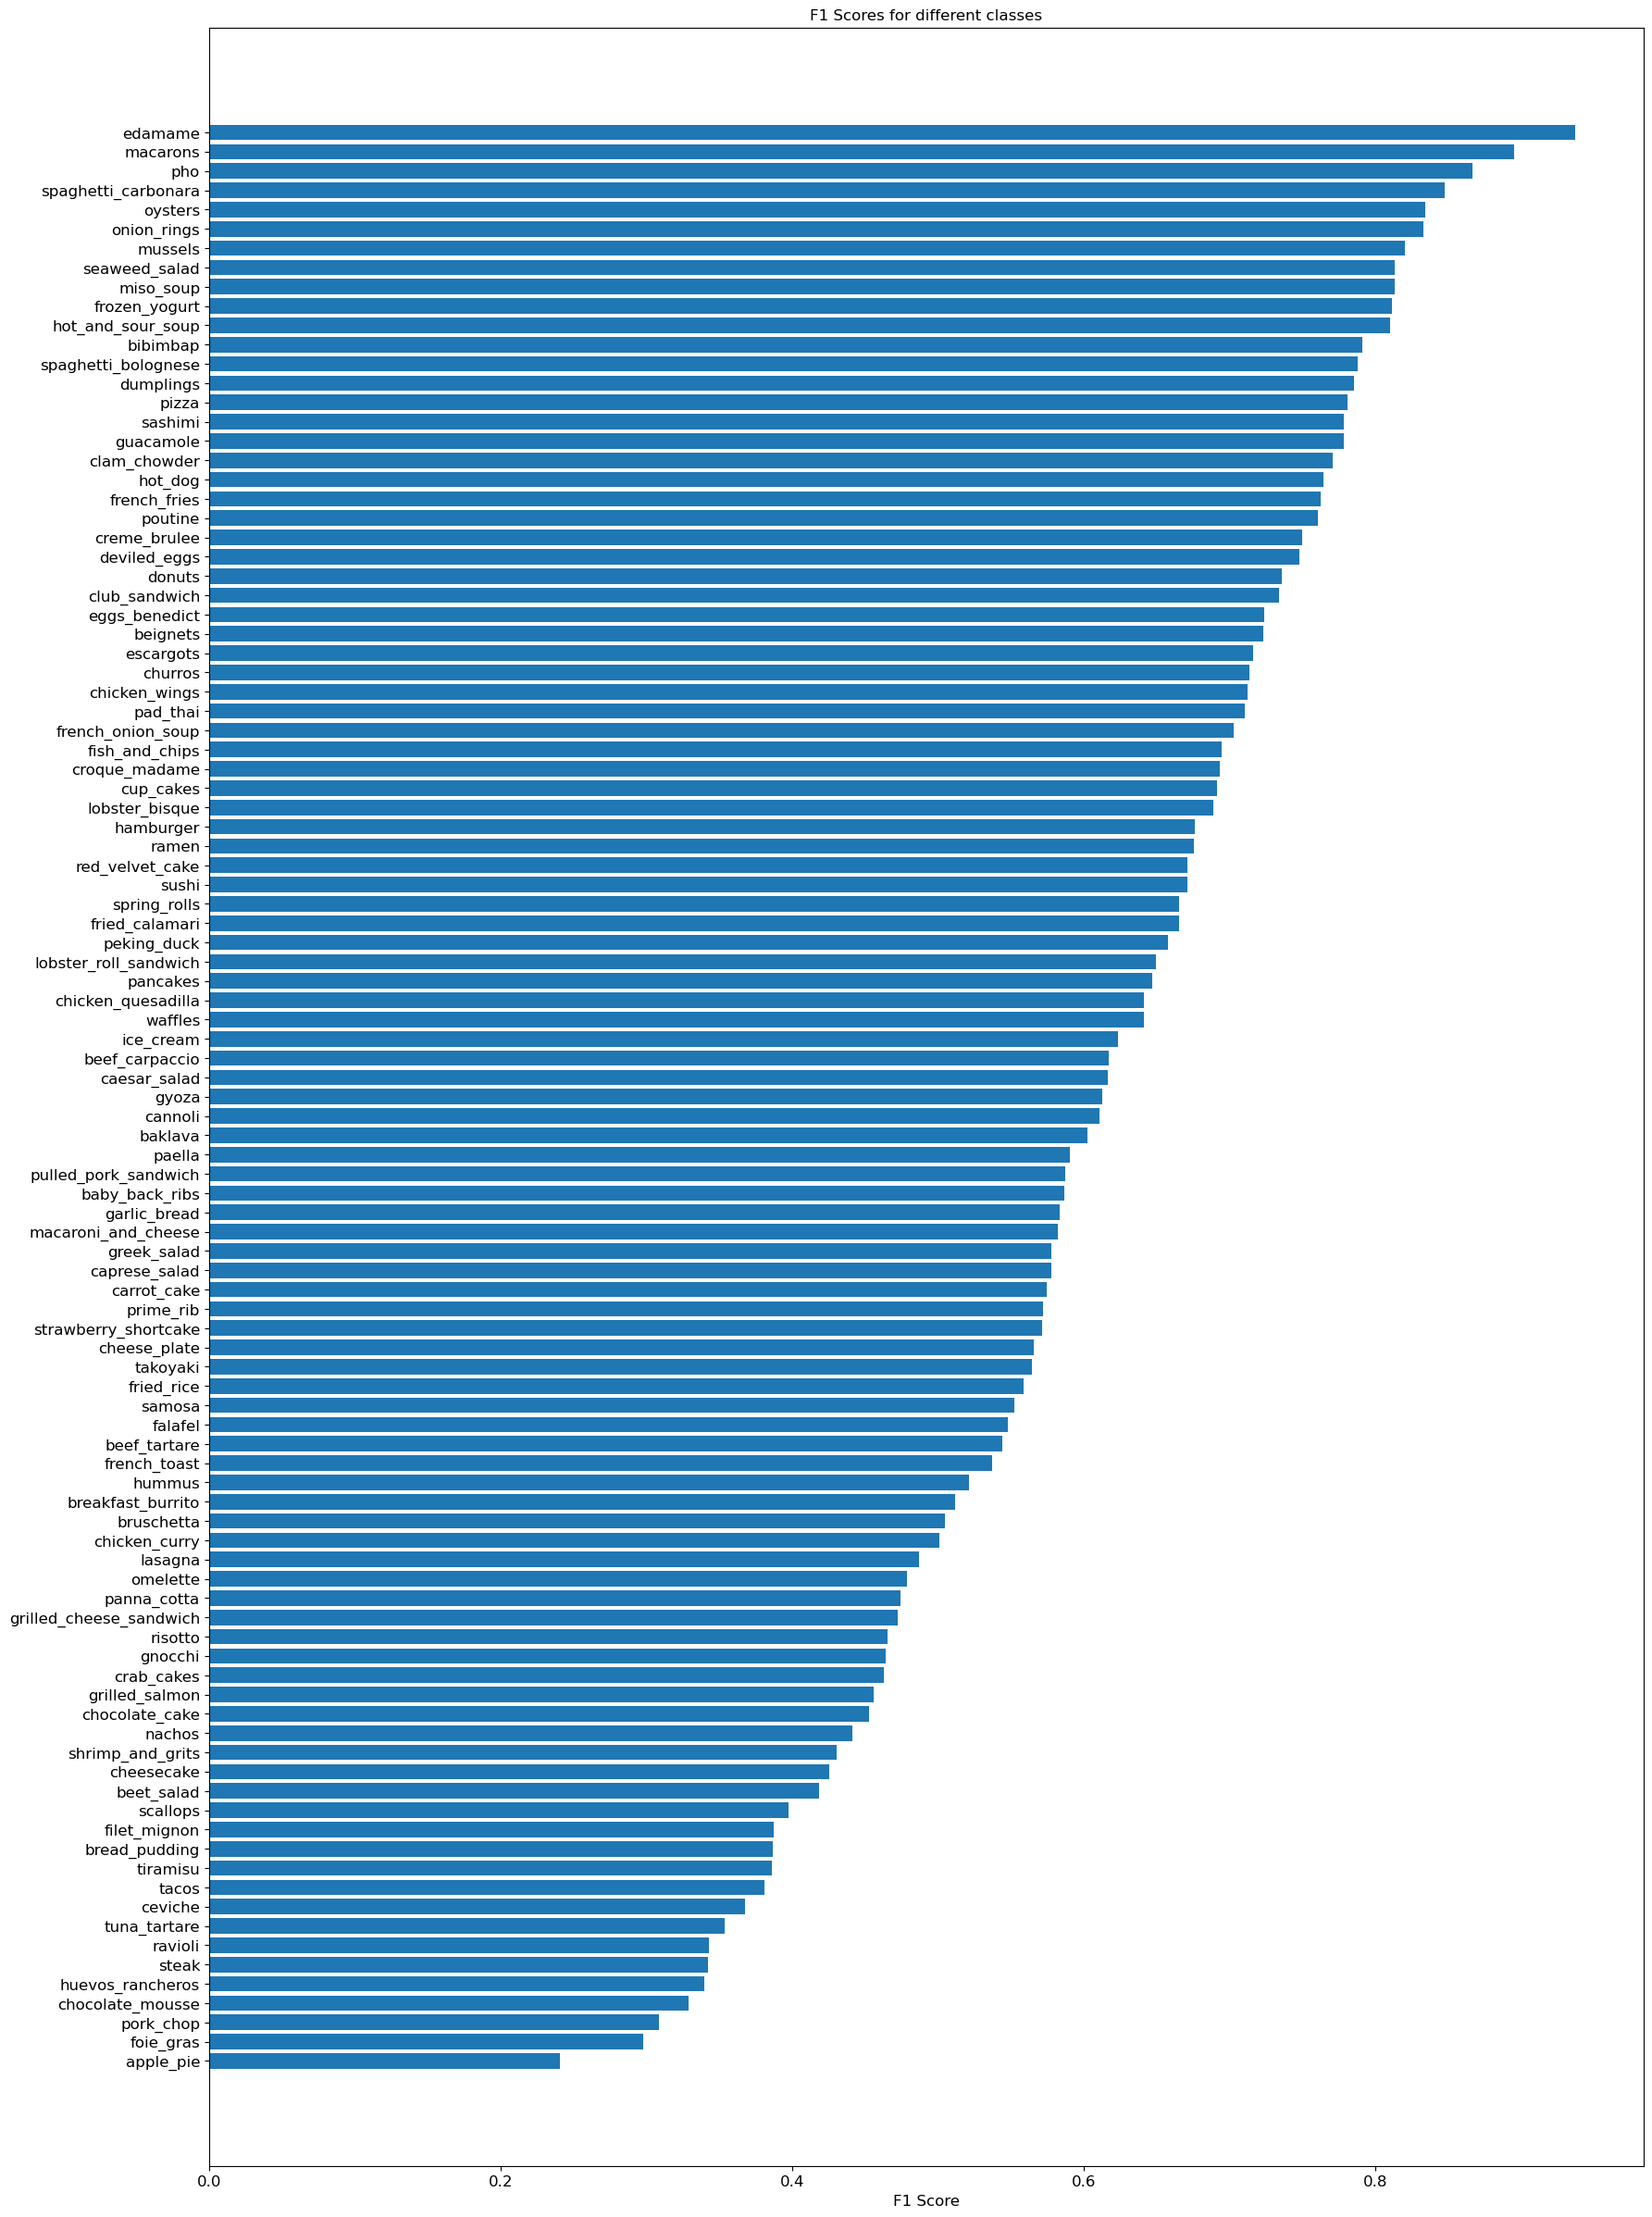

In [52]:
# Visualize f1-scores with my personnal method for visualization
crp.plot_f1_scores(figsize=(20,30))

Video N°198: Creating a function to load and prepa images for making predictions

> 🛠 **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie`, `pork_chip`), do you notice any trends among them? Why might our model be having trouble with them?

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

I already have such a function, see this import from my MachineLearningUtils utility
```python
from MachineLearningUtils.data_visualization.prediction_visualization import prepare_image
prepare_image()
```

Video N°199: Making predictions on our test images and evaluating them

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

In [53]:
train_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


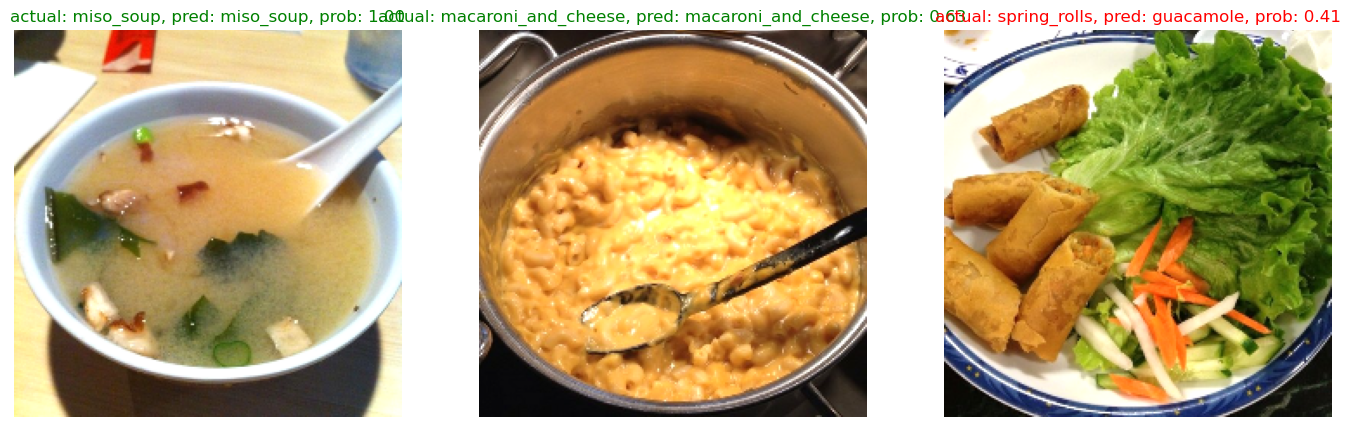

In [54]:
# Make preds on a series of random images
import random
predict_and_display_random_images_from_dir(model=model, dir_path=test_dir, class_names=class_names, num_images=3)

Video N°200: Discussing the benefits of finding your model's most most wrong predictions

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

Video N°201: Writing code to uncover our model's most wrong predictions

In [55]:
ipa = ImagePredictionAnalyzer(y_true=y_labels, y_pred=pred_classes, preds_probs=preds_probs, class_names=class_names, directory=test_dir)

In [56]:
# Create a DataFrame of different parameters for each of our test images
pred_df = ipa.create_prediction_df()
pred_df

img_path  y_true  y_pred  \
0      101_food_classes_10_percent/test/hot_and_sour_...       0      52   
1      101_food_classes_10_percent/test/hot_and_sour_...       0       0   
2      101_food_classes_10_percent/test/hot_and_sour_...       0       0   
3      101_food_classes_10_percent/test/hot_and_sour_...       0      80   
4      101_food_classes_10_percent/test/hot_and_sour_...       0      79   
...                                                  ...     ...     ...   
25245  101_food_classes_10_percent/test/omelette/5240...     100     100   
25246  101_food_classes_10_percent/test/omelette/2245...     100      16   
25247  101_food_classes_10_percent/test/omelette/7244...     100     100   
25248  101_food_classes_10_percent/test/omelette/3616...     100      94   
25249  101_food_classes_10_percent/test/omelette/3252...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847418        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658605        apple_pie  pulled_pork_sandwich         False  
4       0.367903        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972823          waffles               waffles          True  
25246   0.878028          waffles          cheese_plate         False  
25247   0.537899          waffles               waffles          True  
25248   0.501950          waffles  strawberry_shortcake         False  
25249   0.690628          waffles               waffles          True  

[25250 rows x 7 columns]

In [57]:
# Find out in our DataFrame which predictions are wrong
# Sort our DataFrame to have most wrong predictions at the top
top_incorrect = ipa.analyze_incorrect_predictions(top_n=10)
top_incorrect

img_path  y_true  y_pred  \
21810  101_food_classes_10_percent/test/red_velvet_ca...      87      29   
231    101_food_classes_10_percent/test/hot_and_sour_...       0     100   
15359  101_food_classes_10_percent/test/crab_cakes/23...      61      53   
23539  101_food_classes_10_percent/test/donuts/345477...      94      83   
21400  101_food_classes_10_percent/test/lobster_bisqu...      85      92   
24540  101_food_classes_10_percent/test/tacos/729481.jpg      98      83   
2511   101_food_classes_10_percent/test/baby_back_rib...      10      61   
5574   101_food_classes_10_percent/test/macarons/2059...      22      21   
17855  101_food_classes_10_percent/test/lobster_roll_...      71      65   
23797  101_food_classes_10_percent/test/chicken_curry...      95      86   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False

Video N°202: Plotting and visualising the samples our model got most wrong

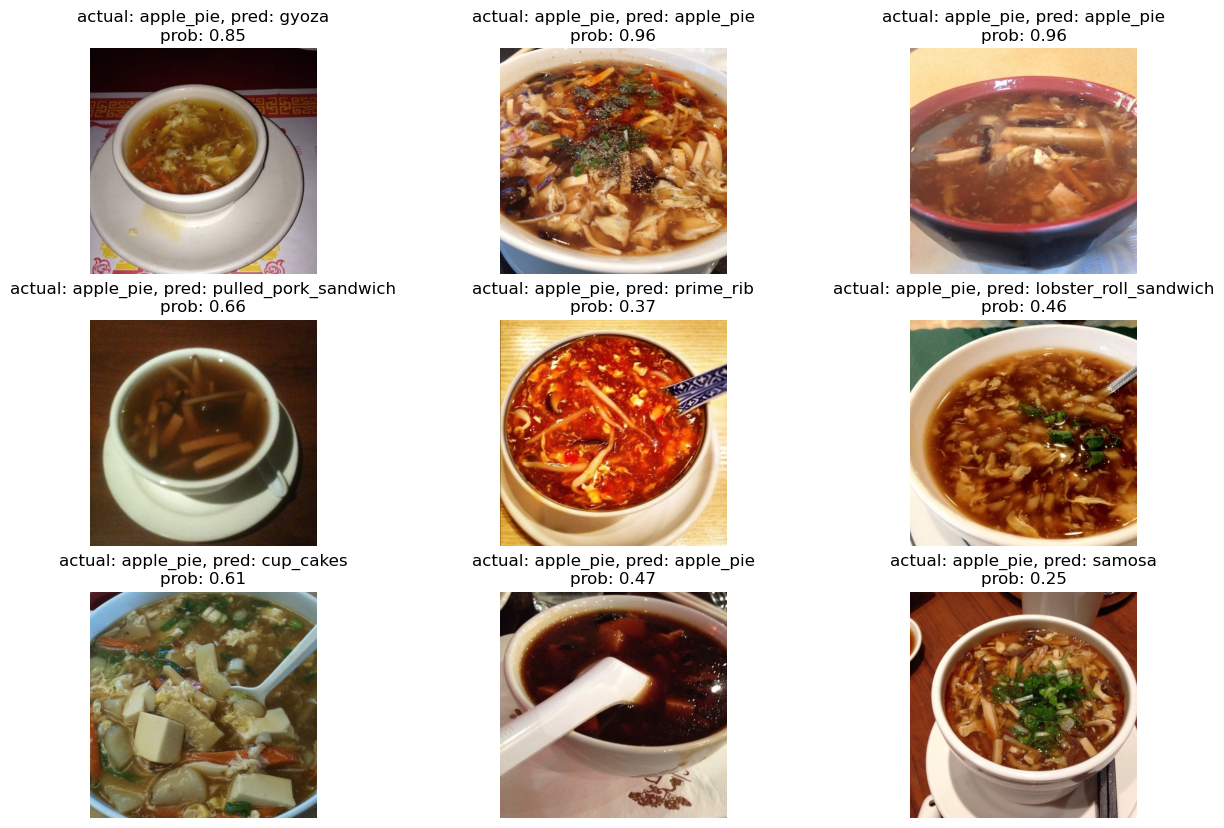

In [98]:
# Visualize the test data samples which have the wrong prediction but highest pred probability
ipa.visualize_predictions(pred_df)

Video N°203: Making predictions on and plotting our own custom images

## Test out the big dog model on our own custom images

In [63]:
# Get custom images
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip"
download_data(url=url, file_path="custom_food_images.zip", extract=True)

--2024-04-18 21:07:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.179.187, 142.250.179.219, 142.251.36.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.179.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: 'custom_food_images.zip'

     0K .......... .......... .......... .......... ..........  0%  309K 42s
    50K .......... .......... .......... .......... ..........  0%  381K 37s
   100K .......... .......... .......... .......... ..........  1% 1.77M 27s
   150K .......... .......... .......... .......... ..........  1% 1.56M 22s
   200K .......... .......... .......... .......... ..........  1% 1.24M 20s
   250K .......... .......... .......... .......... ..........  2% 1.88M 18s
   300K .......... .......... .......... .......... ..........  2% 2.69M 16s
   350K .......... .

custom_food_images.zip has been downloaded.
Extracting custom_food_images.zip as ZIP...
custom_food_images.zip has been extracted to current directory.


.... 90% 16.8M 0s
 11650K .......... .......... .......... .......... .......... 90% 20.2M 0s
 11700K .......... .......... .......... .......... .......... 91% 21.6M 0s
 11750K .......... .......... .......... .......... .......... 91% 19.5M 0s
 11800K .......... .......... .......... .......... .......... 91% 20.0M 0s
 11850K .......... .......... .......... .......... .......... 92% 21.5M 0s
 11900K .......... .......... .......... .......... .......... 92% 8.01M 0s
 11950K .......... .......... .......... .......... .......... 93% 5.73M 0s
 12000K .......... .......... .......... .......... .......... 93% 18.7M 0s
 12050K .......... .......... .......... .......... .......... 93% 21.6M 0s
 12100K .......... .......... .......... .......... .......... 94% 21.6M 0s
 12150K .......... .......... .......... .......... .......... 94% 12.3M 0s
 12200K .......... .......... .......... .......... .......... 95% 21.3M 0s
 12250K .......... .......... .......... .......... .......... 95% 20.

In [65]:
dir_custom_foor_images = Path("custom_food_images")
path_custom_food_images = [str(path) for path in dir_custom_foor_images.rglob('*.jpeg')]
path_custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 22ms/step


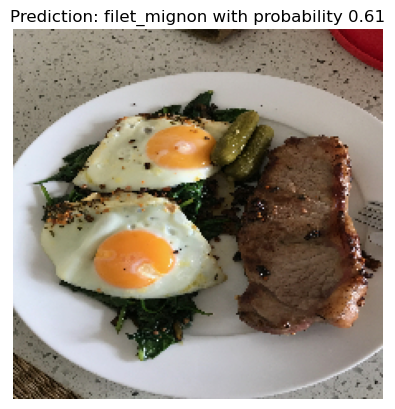

1/1 [==============================] - 0s 20ms/step


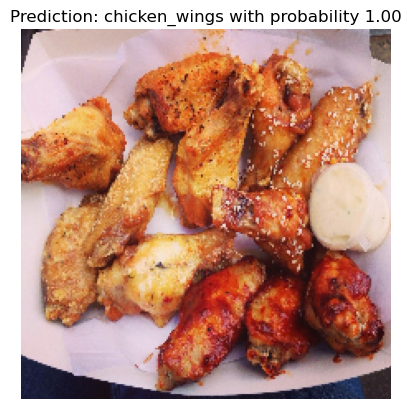

1/1 [==============================] - 0s 20ms/step


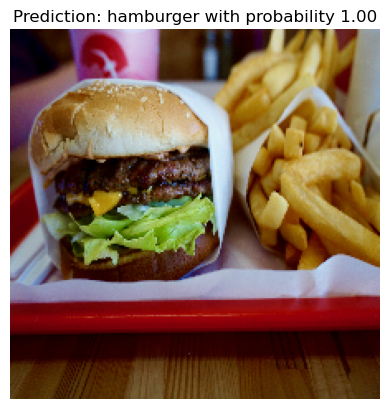

1/1 [==============================] - 0s 21ms/step


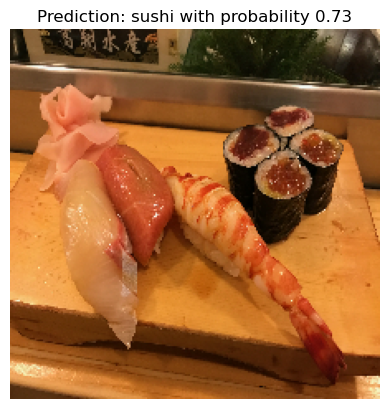

1/1 [==============================] - 0s 29ms/step


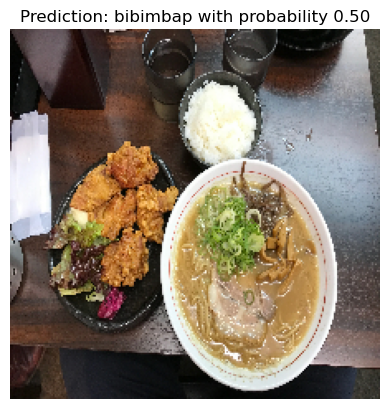

1/1 [==============================] - 0s 22ms/step


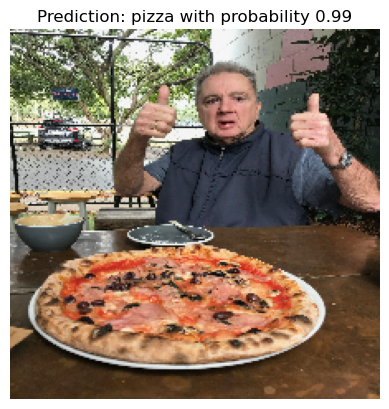

In [97]:
for file_path in path_custom_food_images:
    predict_and_display_image(model=model, file_path=file_path, class_names=class_names, scale=False)